In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns 
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera 
from scipy.stats import normaltest 
from scipy.stats import boxcox 
from scipy.stats import skew
from sklearn.preprocessing import normalize 
from sklearn.preprocessing import scale 
from itertools import cycle, islice
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import math 
import warnings 
import missingno 

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set(style="whitegrid")

## Challenge: Factors that affect life expectancy

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

- First, load the dataset.

- Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

- Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

- In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

- Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

## Life Expectancy (WHO) database, Kagle

### Context
The dataset focuses on immunization factors, mortality factors, economic factors, social factors and other health related factors.  Observations are on a per country basis for whom it is easier to determine the predicting factor which is contributing to a lower value of life expectancy.  The data considers the period from 2000 to 2015 for all the countries.

### Content
The dataset is related to life expectancy health factors for 193 countries collected from the WHO data repository.  The corresponding economic data was collected from the United Nations website.  The final dataset consists of 22 columns and 2938 rows with 20 predicting variables.  All of the predicting variables can be divided into several broad categories: Immunization related factors, Mortality factors, Economic Factors and Social factors.

### Variables
-	Country: Country | 193 unique values
-	Year: Year | 2000 – 2015
-	Status: Developed or Developing | Developing (83%), Developed (17%) 
-	Life expectancy: Life Expectancy in age (years) | 36.3 - 89
-	Adult Mortality: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population) | 1 - 723
-	Infant deaths: Number of Infant Deaths per 1000 population | 0 - 1800
-	Alcohol: Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) | 0.01 – 17.9
-	Percentage expend: Expenditure on health as a percentage of Gross Domestic Product per capita (%) | 0 – 19,500
-	Hepatitis B: Hepatitis B (HepB) immunization coverage among 1-year-olds (%) | 1 - 99
-	Measles: Measles - number of reported cases per 1000 population | 0 – 212,000
-	BMI: Average Body Mass Index of entire population | 1 – 87.3
-	Under-five-deaths: Number of under-five deaths per 1000 population | 0 - 2500
-	Polio: Polio (Pol3) immunization coverage among 1-year-olds (%) | 3 - 99
-	Total Expenditure: General government expenditure on health as a percentage of total government expenditure (%) | 0.37 – 17.6
-	Diphtheria: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%) | 2 - 99
-	HIV/AIDS: Deaths per 1 000 live births HIV/AIDS (0-4 years) | 0.1 – 50.6
-	GDP: Gross Domestic Product per capita (in USD) | 1.68 – 119,000
-	Population: Population of the country | 34 – 1,290,000,000
-	Thinness 1-19 years: Prevalence of thinness among children and adolescents for Age 10 to 19 (%) | 0.1 – 27.7
-	Thinness 5-9 years: Prevalence of thinness among children for Age 5 to 9(%) | 0.1 – 28.6



In [2]:
kagle = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="lifeexpectancy"
)

engine = create_engine(URL(**kagle), echo=True)

life_expectancy_raw = pd.read_sql_query("SELECT * FROM lifeexpectancy", con=engine)

engine.dispose()

2019-12-09 11:13:41,296 INFO sqlalchemy.engine.base.Engine select version()
2019-12-09 11:13:41,297 INFO sqlalchemy.engine.base.Engine {}
2019-12-09 11:13:41,910 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-09 11:13:41,911 INFO sqlalchemy.engine.base.Engine {}
2019-12-09 11:13:42,263 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-09 11:13:42,264 INFO sqlalchemy.engine.base.Engine {}
2019-12-09 11:13:42,439 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-09 11:13:42,440 INFO sqlalchemy.engine.base.Engine {}
2019-12-09 11:13:42,616 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-09 11:13:42,617 INFO sqlalchemy.engine.base.Engine {}
2019-12-09 11:13:42,969 INFO sqlalchemy.engine.base.Engine SELECT * FROM lifeexpectancy
2019-12-09 11:13:42,973 INFO sqlalchemy.engine.base.Engine {}


In [3]:
# Take an intial peek at the dataset
life_expectancy_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
# The column headers are a mess, clean them up and standardize them
# Strip leading and trailing whitespace from the column headers 
life_expectancy_raw.columns = life_expectancy_raw.columns.str.strip()
# Lowercase the column headers
life_expectancy_raw.columns = life_expectancy_raw.columns.str.lower()
# Replace spaces between words with underscores
life_expectancy_raw.columns = life_expectancy_raw.columns.str.replace(" ", "_")

life_expectancy_raw.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness__1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

In [5]:
# Adjust data types 
# Alter the column types for the "country" and "status" variables
life_expectancy_raw[["country", "status"]] = life_expectancy_raw[["country", "status"]].astype("category")
# Change the "year" variable to datetime
life_expectancy_raw["year"] = pd.to_datetime(life_expectancy_raw["year"], format="%Y")
life_expectancy_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null category
year                               2938 non-null datetime64[ns]
status                             2938 non-null category
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           

In [6]:
# Take an initial look at nulls in the data
def null_report(df):
    categorical_cols = df.select_dtypes(include="category").columns
    continuous_cols = df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns

    # Create a rowcount variable
    df_len = len(df)

    # Calculated the width of the longest column
    max_col = len(max(df.columns, key=len))

    for col in categorical_cols: 
        # Use sorted function to generate a list of the 5 shortest categories
        short_cats = sorted(set(df[col]), key=len)[:5]
        print(f"First five shortest strings in '{col}': {short_cats}")

    # Look at null value information for continuous variables
    for col in categorical_cols:
        empty_strings = len(df.loc[df[col]==''])
        nulls = df[col].isna().sum()
        tot_nulls = empty_strings + nulls
        pct_nan = tot_nulls*100/df_len
        unique_vals = df[col].nunique()
        print(f"{col:<{max_col}}: {tot_nulls:>{5}} nulls | percent null: {pct_nan:>{5}.2f} | unique values: {unique_vals:>{24},.2f}")

    # Look a null value information for continuous variables
    for col in continuous_cols:
        nulls = df[col].isnull().sum()
        pct_null = nulls*100/df_len
        var = df[col].var()
        print(f"{col:<{max_col}}: {nulls:>{5}} nulls | percent null: {pct_null:>{5}.2f} | col variance: {var:>{25},.2f}")

null_report(life_expectancy_raw)

First five shortest strings in 'country': ['Niue', 'Togo', 'Fiji', 'Chad', 'Oman']
First five shortest strings in 'status': ['Developed', 'Developing']
country                        :     0 nulls | percent null:  0.00 | unique values:                   193.00
status                         :     0 nulls | percent null:  0.00 | unique values:                     2.00
life_expectancy                :    10 nulls | percent null:  0.34 | col variance:                     90.70
adult_mortality                :    10 nulls | percent null:  0.34 | col variance:                 15,448.52
infant_deaths                  :     0 nulls | percent null:  0.00 | col variance:                 13,906.66
alcohol                        :   194 nulls | percent null:  6.60 | col variance:                     16.42
percentage_expenditure         :     0 nulls | percent null:  0.00 | col variance:              3,951,805.48
hepatitis_b                    :   553 nulls | percent null: 18.82 | col variance:   

Number of null values: 1289


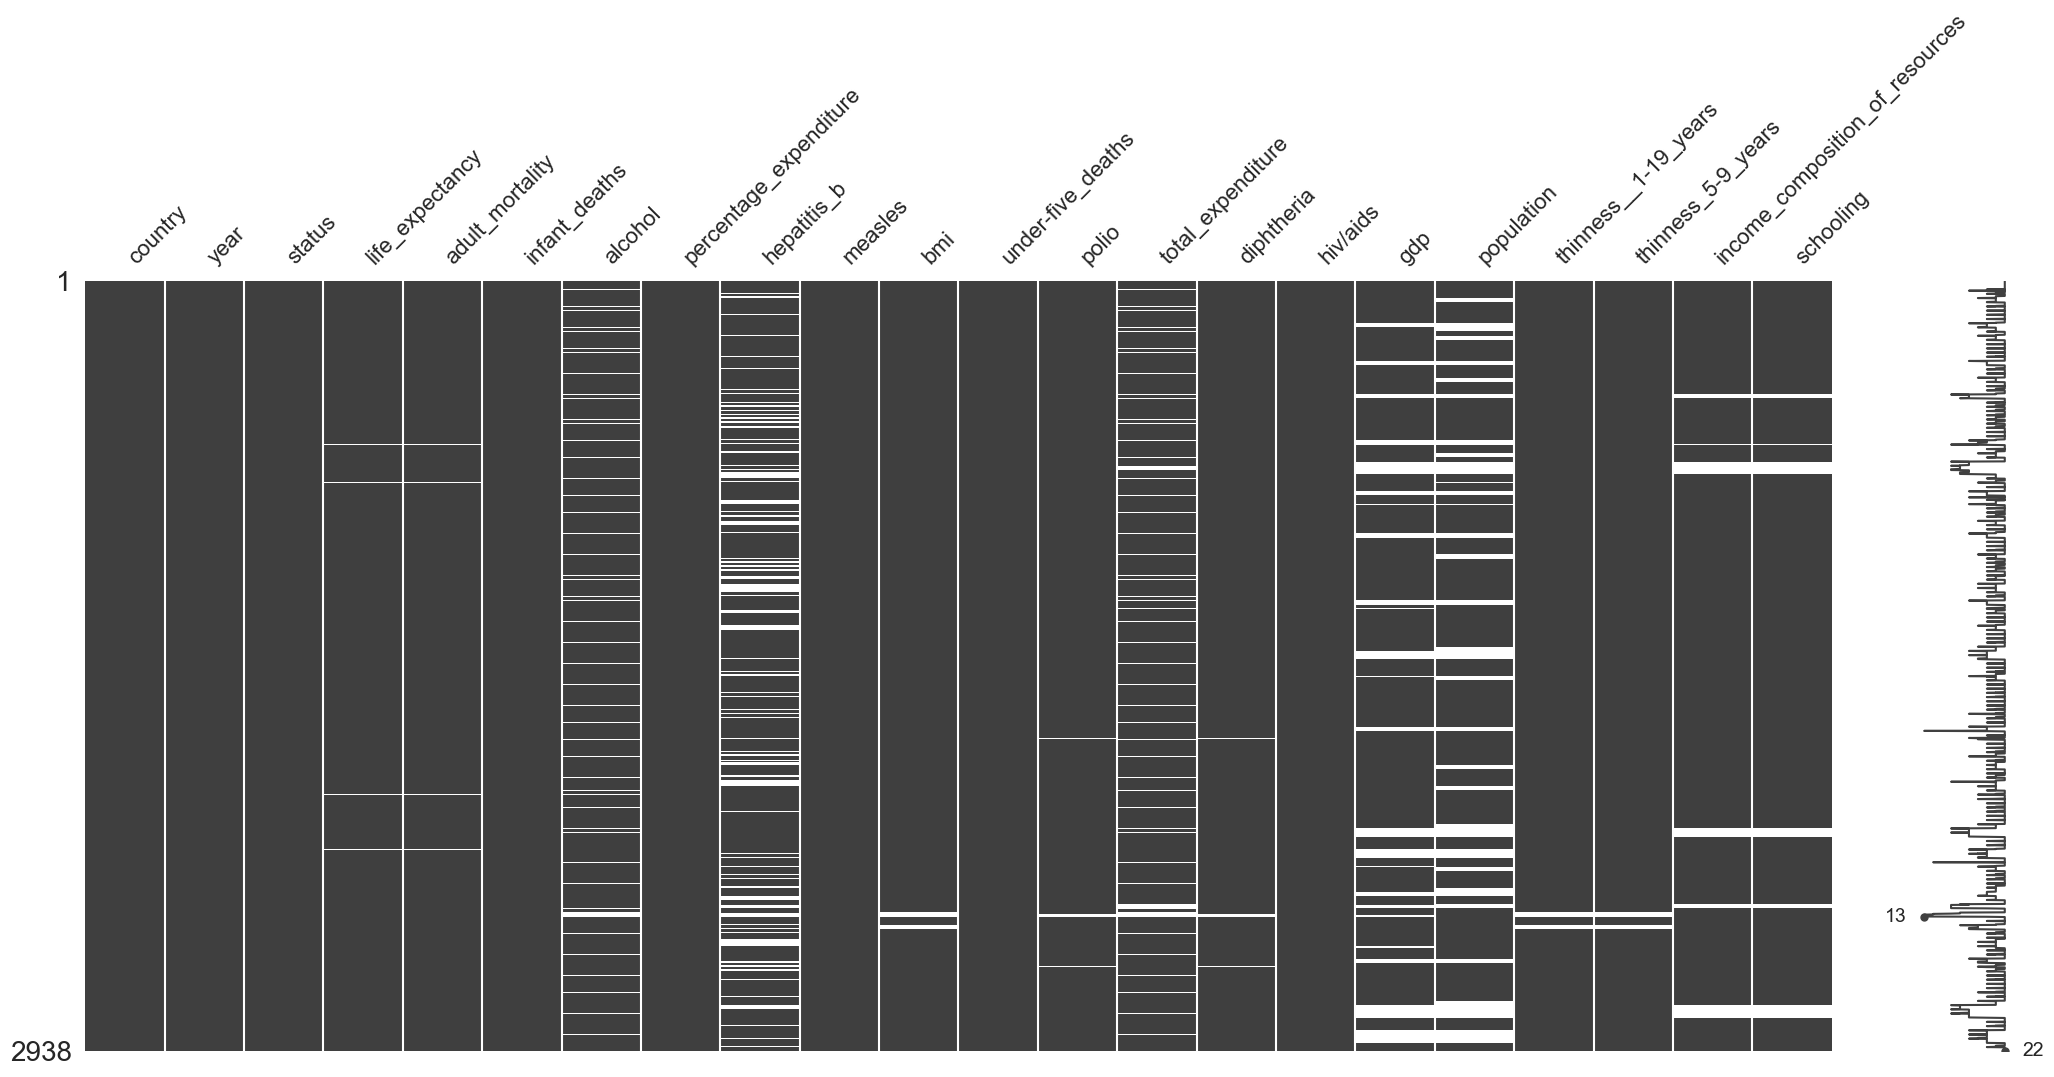

In [7]:
# Generate a visual representation of nulls in the dataset
def report_null_entries(df):
    if len(df[df.isnull().any(axis=1)] != 0):
        print(f"Number of null values: {len(df[df.isnull().any(axis=1)])}")
        missingno.matrix(df)
        plt.show()
    else:
        print("No rows with null values found.")

report_null_entries(life_expectancy_raw)

First five shortest strings in 'country': ['Niue', 'Togo', 'Fiji', 'Chad', 'Oman']
First five shortest strings in 'status': ['Developed', 'Developing']
country                        :     0 nulls | percent null:  0.00 | unique values:                   193.00
status                         :     0 nulls | percent null:  0.00 | unique values:                     2.00
life_expectancy                :    10 nulls | percent null:  0.34 | col variance:                     90.70
adult_mortality                :    10 nulls | percent null:  0.34 | col variance:                 15,448.52
infant_deaths                  :     0 nulls | percent null:  0.00 | col variance:                 13,906.66
alcohol                        :    17 nulls | percent null:  0.58 | col variance:                     16.57
percentage_expenditure         :     0 nulls | percent null:  0.00 | col variance:              3,951,805.48
hepatitis_b                    :   144 nulls | percent null:  4.90 | col variance:   

None

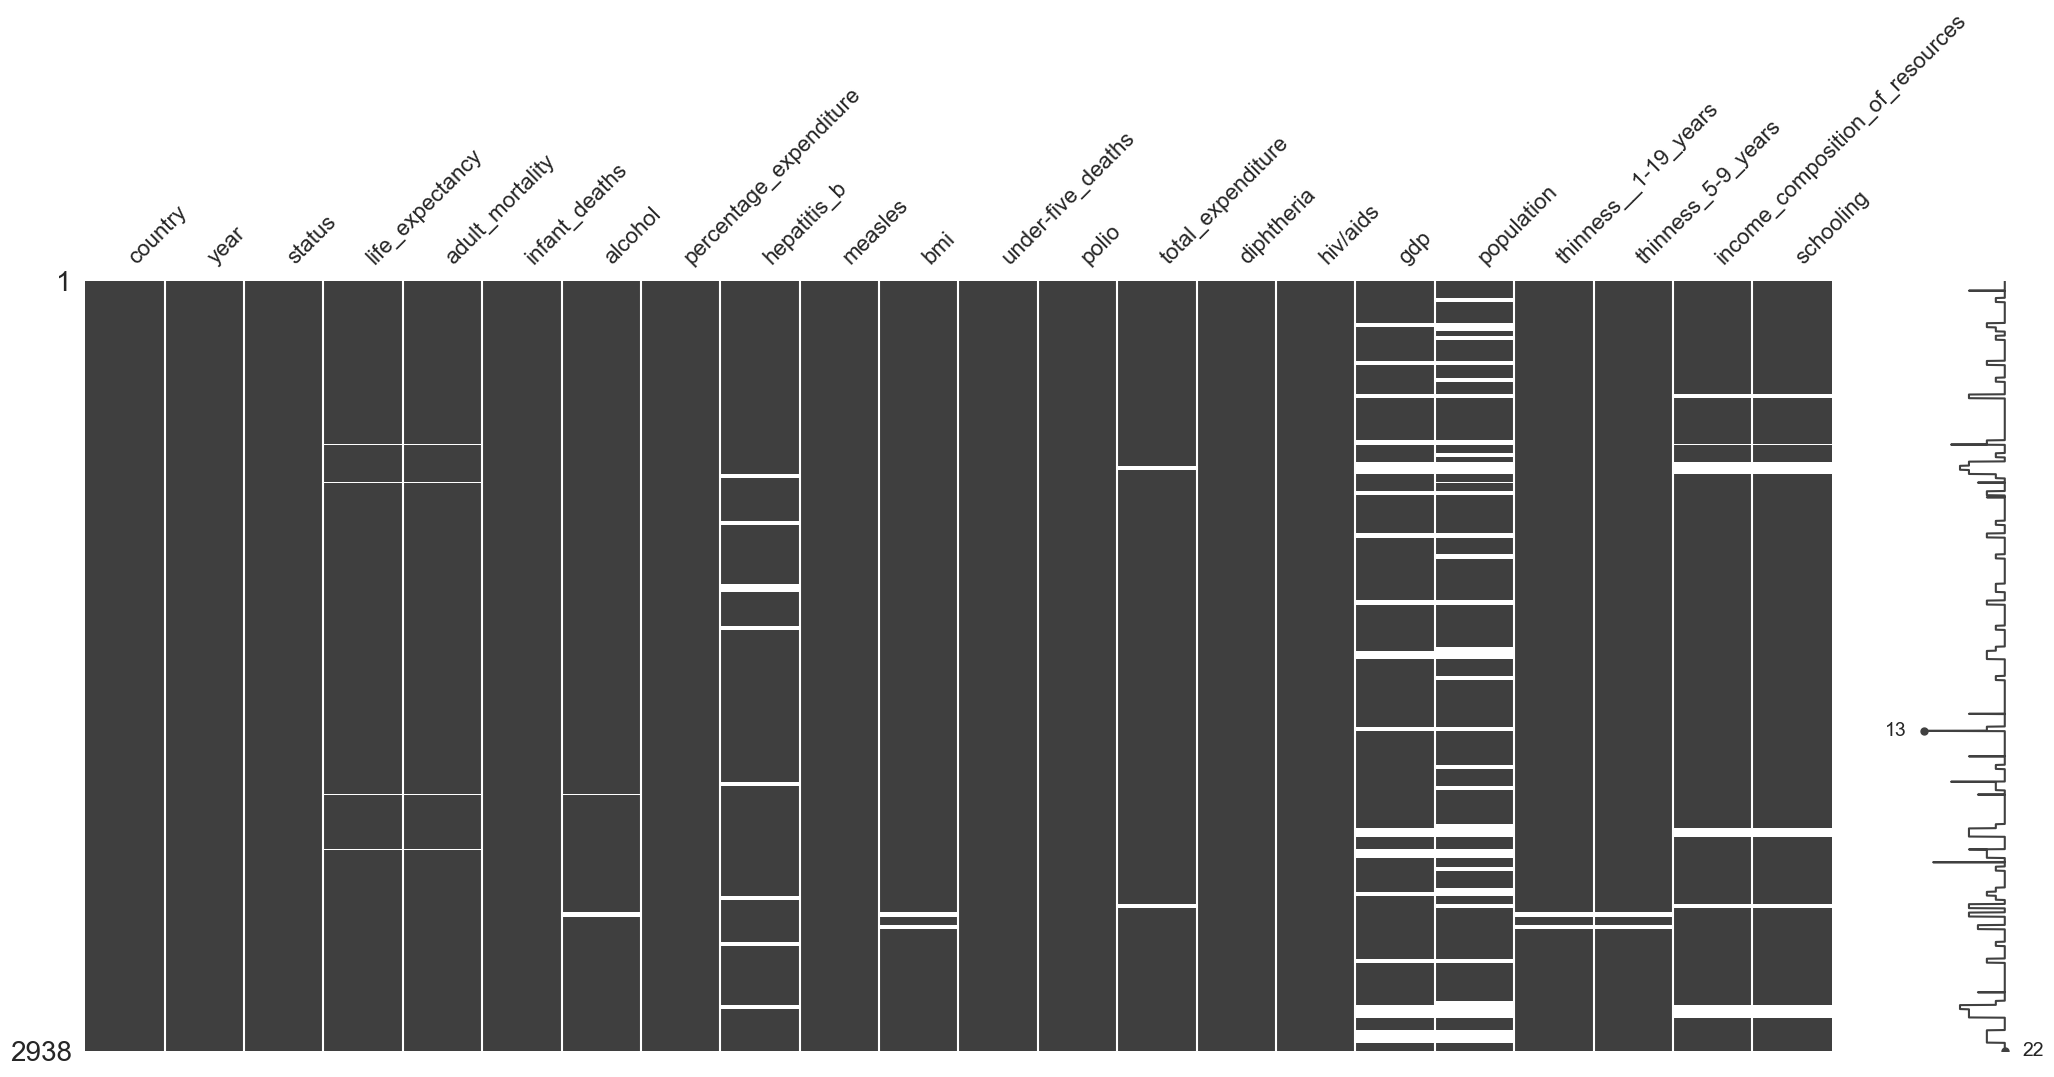

None

In [9]:
# Work on a copy of the raw data
life_expectancy_interpolated = life_expectancy_raw.copy()

# Get a list of countries to group by 
countries = life_expectancy_interpolated["country"].unique()

# Select the continuous columns into a variable for use in a loop
continuous_cols = life_expectancy_interpolated.select_dtypes(exclude= \
    ['object','category','datetime64[ns]']).columns

# Loop over the countries and interpolate missing data
for country in countries: 
    life_expectancy_interpolated.loc[life_expectancy_interpolated["country"]==country, continuous_cols] = \
        life_expectancy_interpolated.loc[life_expectancy_interpolated["country"]== \
            country, continuous_cols].interpolate(limit_direction="both")

display(null_report(life_expectancy_interpolated))
display(report_null_entries(life_expectancy_interpolated))

After interpolation there are still null values present in the data.  This is due to grouping the data by country prior to interpolation because there is insufficient data for some countries to interpolate.  Replace remaining null values with the mean value for each year.

In [11]:
# Get a list of countries to group by 
life_expectancy_df = life_expectancy_interpolated.copy()
continuous_cols = life_expectancy_df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns

for col in continuous_cols: 
    life_expectancy_df[col] = life_expectancy_df.groupby("year")[col]\
        .transform(lambda x: x.fillna(x.mean()))

print("Mean replacement complete.")

# Run the null report to verify elimination of null values
display(null_report(life_expectancy_df))

Mean replacement complete.
First five shortest strings in 'country': ['Niue', 'Togo', 'Fiji', 'Chad', 'Oman']
First five shortest strings in 'status': ['Developed', 'Developing']
country                        :     0 nulls | percent null:  0.00 | unique values:                   193.00
status                         :     0 nulls | percent null:  0.00 | unique values:                     2.00
life_expectancy                :     0 nulls | percent null:  0.00 | col variance:                     90.41
adult_mortality                :     0 nulls | percent null:  0.00 | col variance:                 15,396.79
infant_deaths                  :     0 nulls | percent null:  0.00 | col variance:                 13,906.66
alcohol                        :     0 nulls | percent null:  0.00 | col variance:                     16.47
percentage_expenditure         :     0 nulls | percent null:  0.00 | col variance:              3,951,805.48
hepatitis_b                    :     0 nulls | percent nul

None

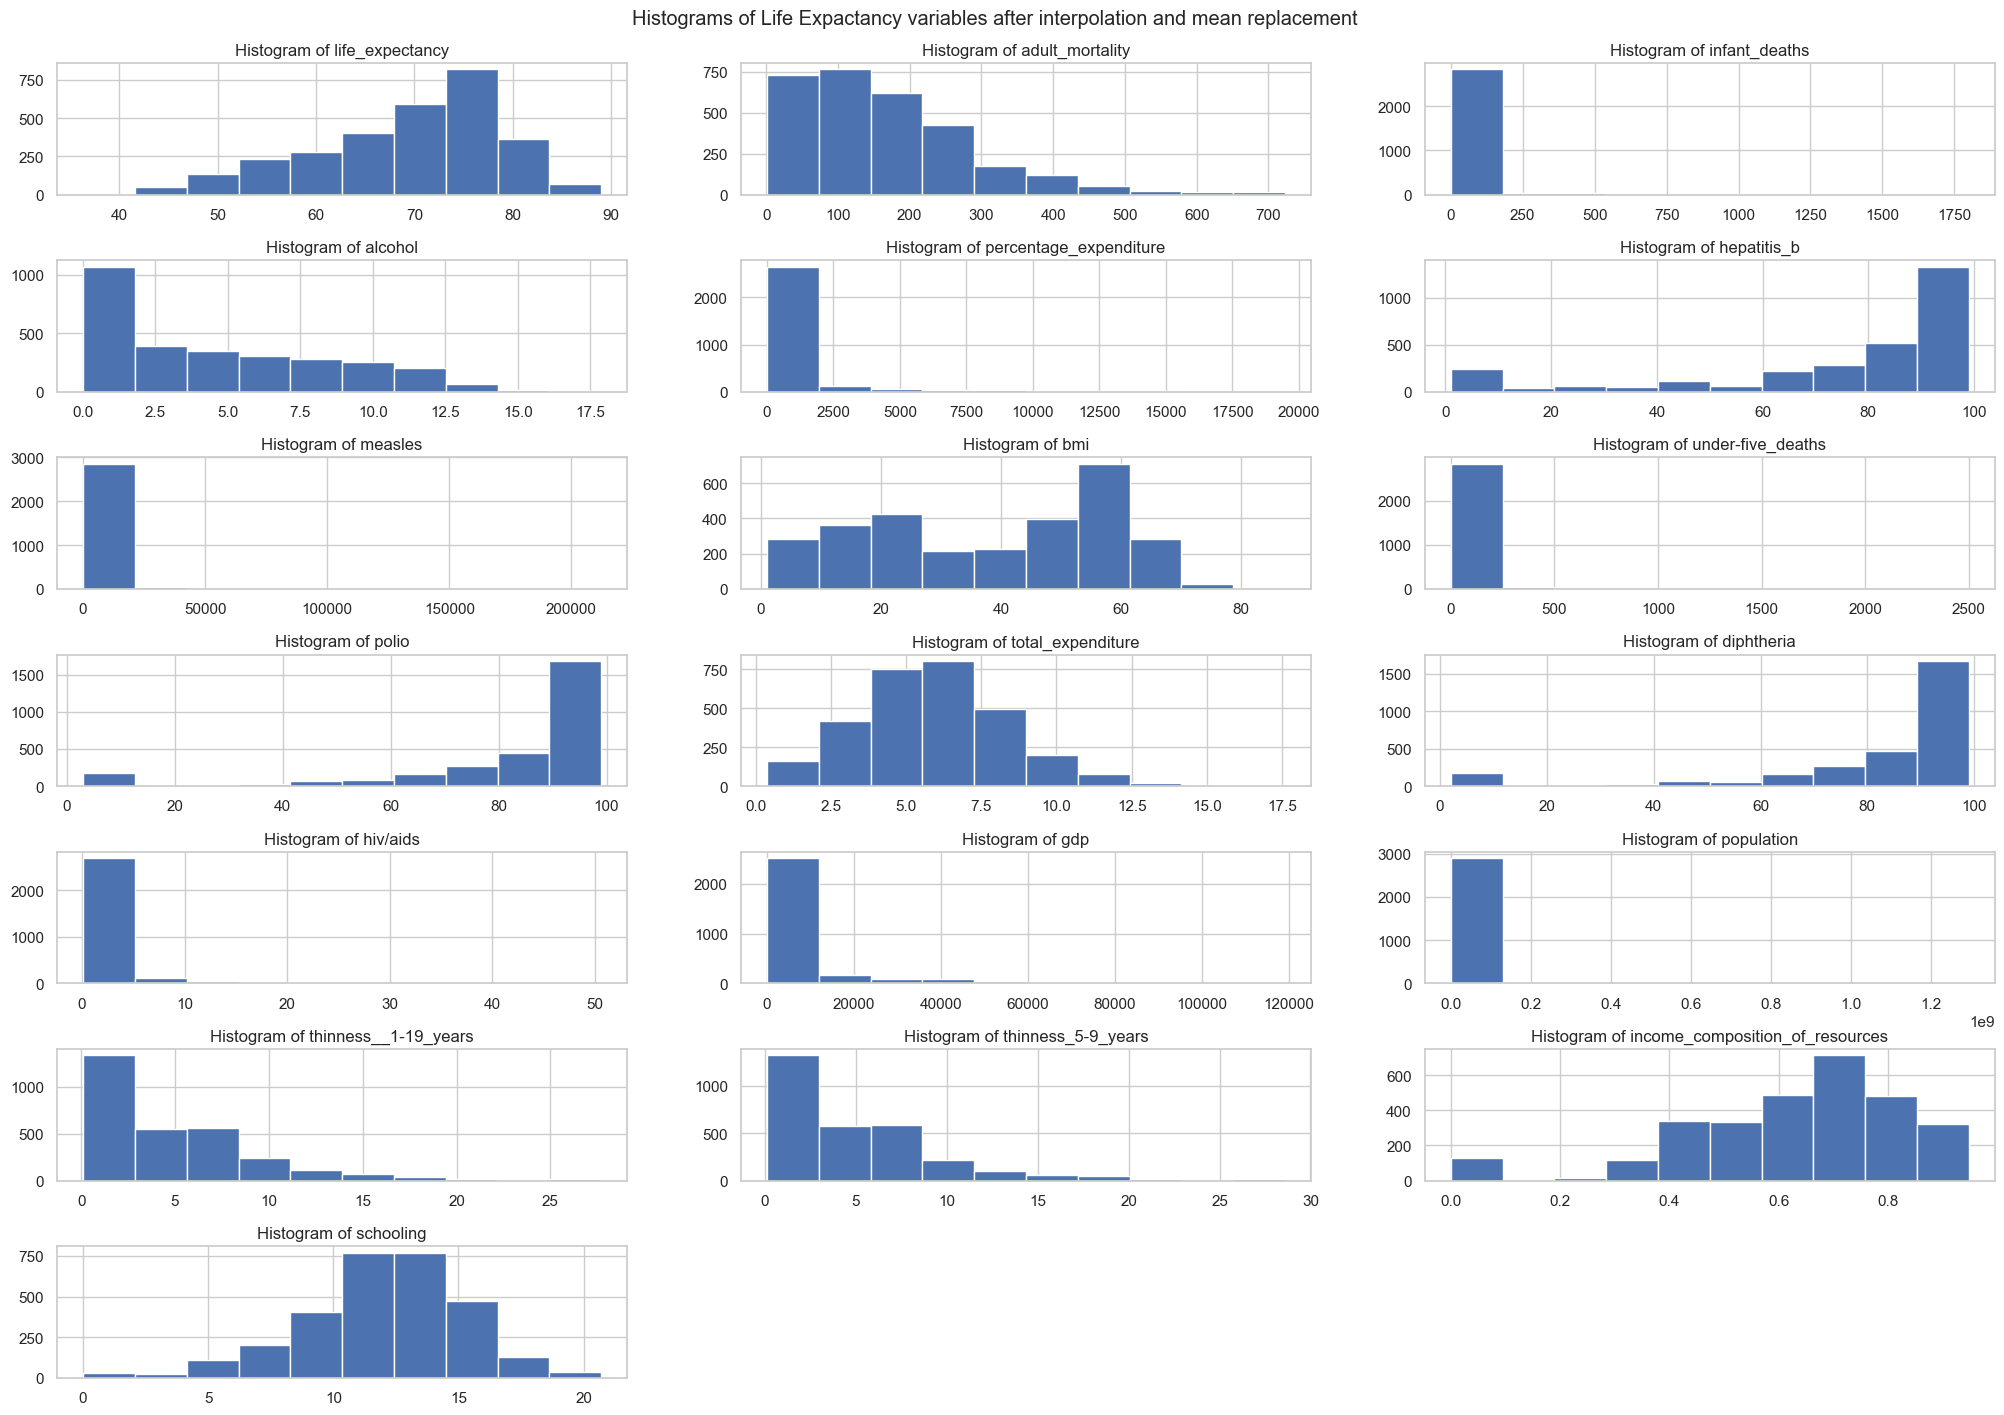

In [14]:
# Take an initial look at the distributions for the continuious variables
df = life_expectancy_df.select_dtypes(exclude=['object','category','datetime64[ns]'])
fsize = (25,18)

plt.figure(figsize=fsize)

for i in range(df.shape[1]): 
    col = df.iloc[:, [i]].columns[0]
    plt.subplot(8,3,(i+1))
    plt.hist(life_expectancy_df[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables after interpolation and mean replacement")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show()

### Outlier Detection
_Outliers_ tend to skew the descriptive statistics for a given dataset.  The statistical mean is highly prone to skewing due to outliers.   Additionally, some machine learning models are sensitive to extreme values which impacts their ability to produce accurate estimates.

Regarding the dataset being considered, there are several variables that might have some nonsense values.  Not on the high side but abnormally low on a per 1000 population basis (Infant Deaths, Measles, and Under-five-deaths).  These might stem from under reporting or failure to report.

There are two common techniques for dealing with outliers: 

_Z-Score_: To calculate Z-score, first, scale the variable so that its mean is 0 and it's standard deviation is 1.  Then measure how far a value is away from the mean (0) in terms of standard deviations (1).  The bigger the Z-score value, the farther it is from the mean and the more likely it is an outlier.

_Turkey's Method (IQR Method)_: This method consideres all values that are outside the threshold of 1.5 times the Interquartile Range (IQR) as outliers.  You can also changes the threshold to other values.


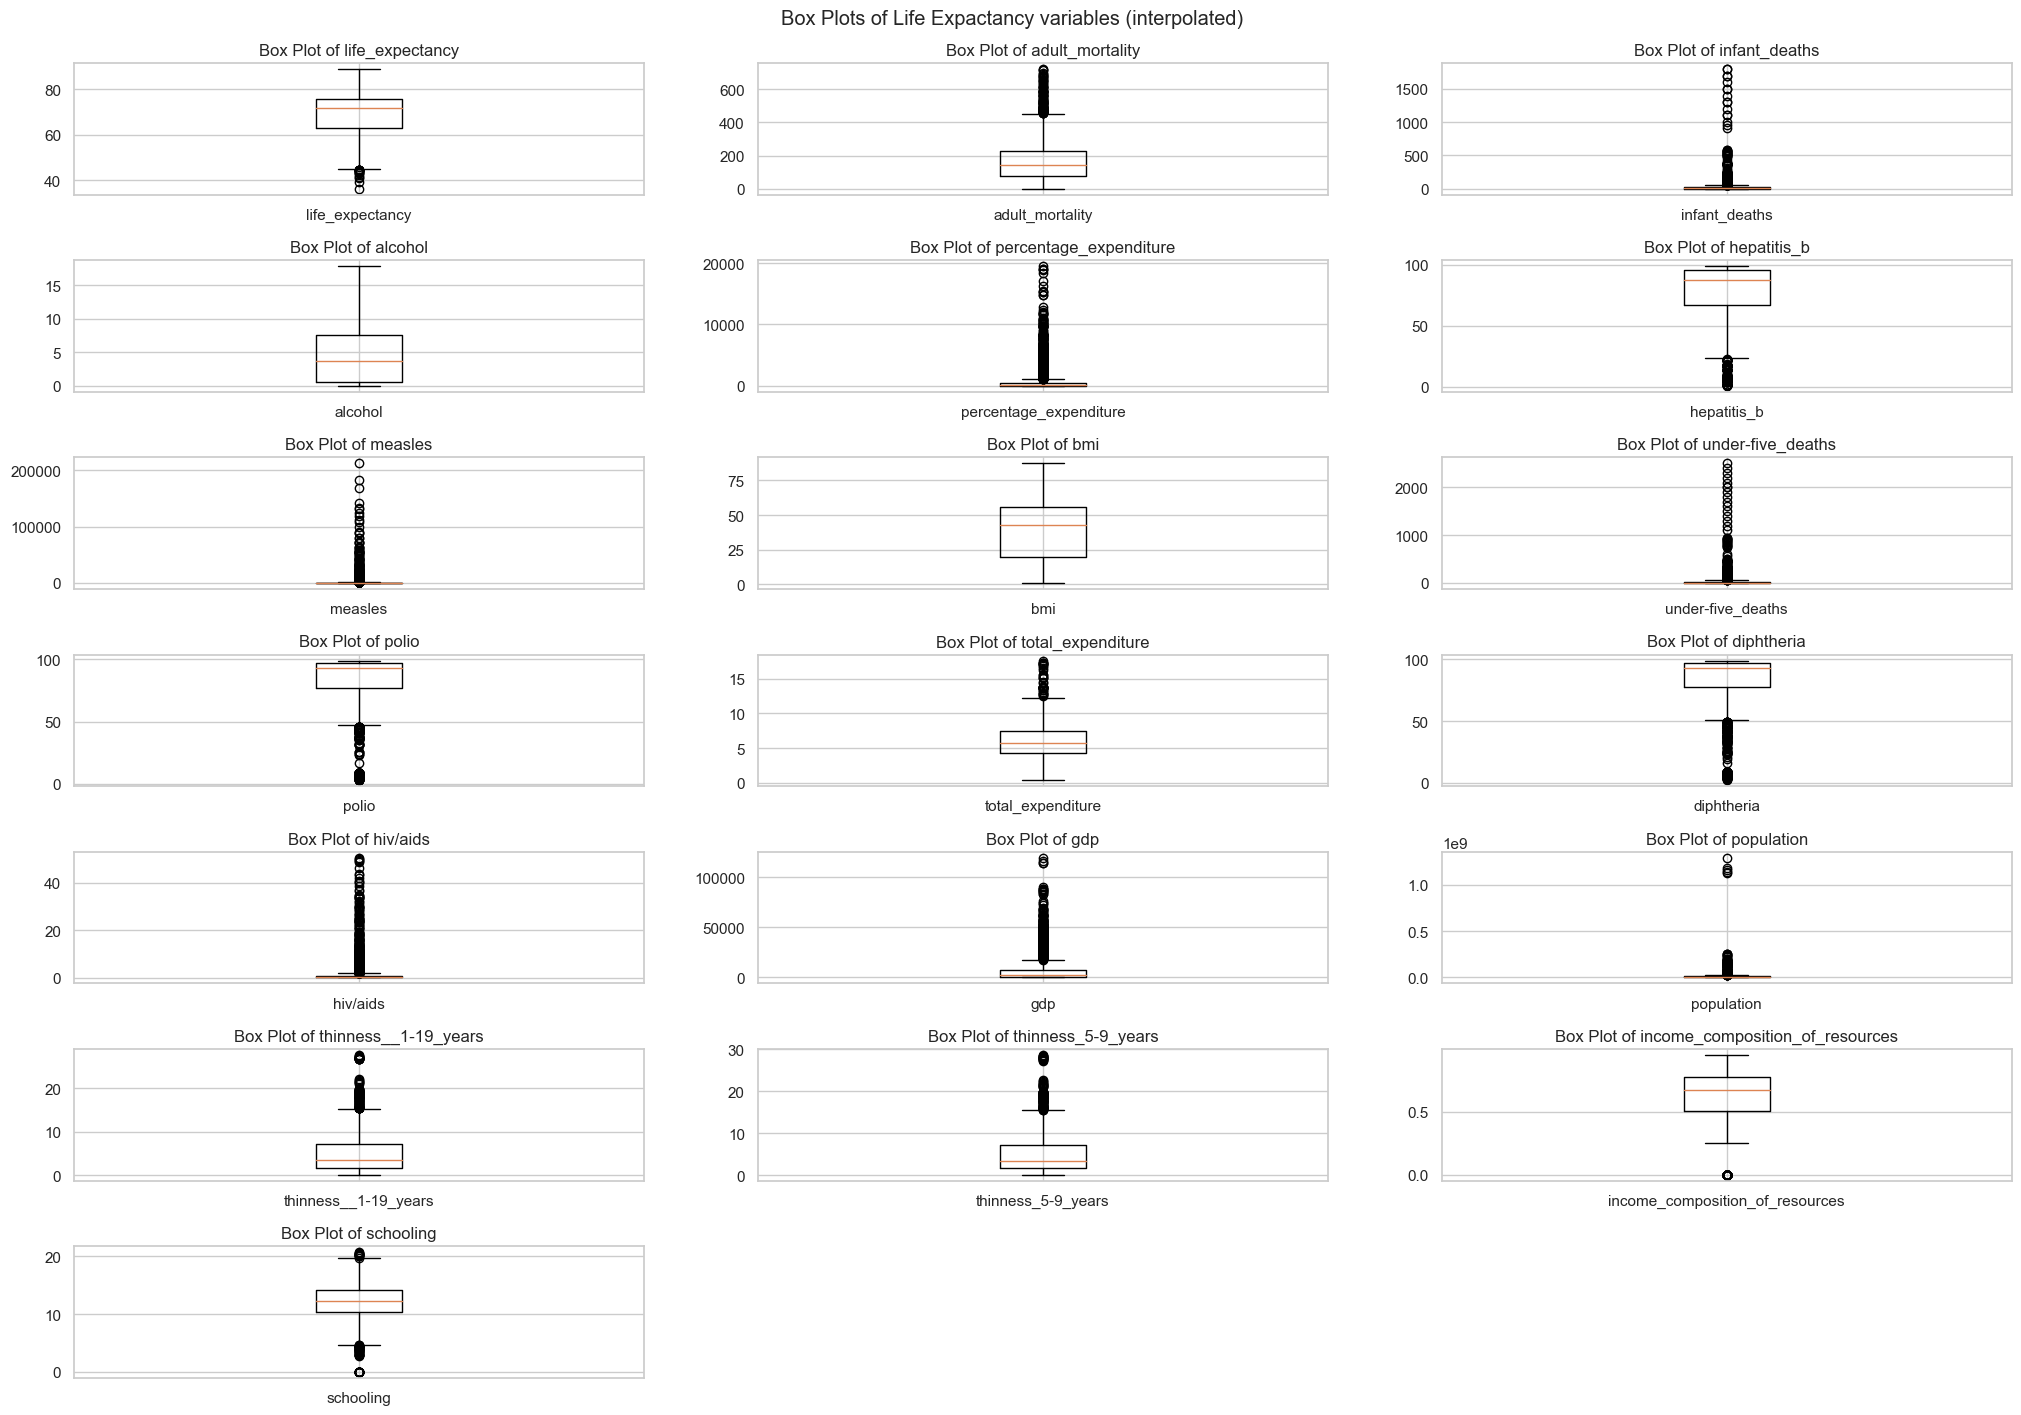

In [16]:
# Take an initial look at the data with box plots to get a feel for outliers
plt.figure(figsize=fsize)

for i in range(df.shape[1]): 
    col = df.iloc[:, [i]].columns[0]
    plt.subplot(8,3,(i+1))
    plt.boxplot(life_expectancy_df[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of {col}")

plt.suptitle("Box Plots of Life Expactancy variables (interpolated)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [18]:
# Use Z-Scores to establish a threshold for outliers
def run_z_score(df):
    continuous_cols = df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns
    for col in continuous_cols:
        z_scores = zscore(df[col])
        print(f"Variable: {col}:")
        for threshold in range(1,7): 
            print(f"\tZ-Score threshold: {threshold} | Number of outliers is: ", 
                f"{len(np.where(z_scores > threshold)[0])}")
        print(100*"=")

# Run the run_z_score function 
run_z_score(life_expectancy_df)

Variable: life_expectancy:
	Z-Score threshold: 1 | Number of outliers is:  400
	Z-Score threshold: 2 | Number of outliers is:  11
	Z-Score threshold: 3 | Number of outliers is:  0
	Z-Score threshold: 4 | Number of outliers is:  0
	Z-Score threshold: 5 | Number of outliers is:  0
	Z-Score threshold: 6 | Number of outliers is:  0
Variable: adult_mortality:
	Z-Score threshold: 1 | Number of outliers is:  405
	Z-Score threshold: 2 | Number of outliers is:  139
	Z-Score threshold: 3 | Number of outliers is:  40
	Z-Score threshold: 4 | Number of outliers is:  11
	Z-Score threshold: 5 | Number of outliers is:  0
	Z-Score threshold: 6 | Number of outliers is:  0
Variable: infant_deaths:
	Z-Score threshold: 1 | Number of outliers is:  110
	Z-Score threshold: 2 | Number of outliers is:  56
	Z-Score threshold: 3 | Number of outliers is:  37
	Z-Score threshold: 4 | Number of outliers is:  29
	Z-Score threshold: 5 | Number of outliers is:  16
	Z-Score threshold: 6 | Number of outliers is:  16
Varia

In [45]:
# Use the IQR Method to establish a threshold for outliers
def run_iqr_method(df):
    continuous_cols = df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns
    for col in continuous_cols: 
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25

        print(f"Variable: {col}")
        for threshold in np.arange(1,100,0.5): 
            min_val = q25 - (iqr*threshold)
            max_val = q75 + (iqr*threshold)
            outliers = len((np.where((df[col] > max_val) 
                        | (df[col] < min_val))[0]))
            if outliers == 0: 
                print(f"\tIQR Threshold: {threshold:>{4}.1f} | Outliers: {outliers} |"\
                    f" {min_val/len(df):.2f},"\
                    f" {max_val/len(df):.2f}")
                break
        print(100*"=")

# Run Turkey's method function on life_expectancy_df
run_iqr_method(life_expectancy_df)

Variable: life_expectancy
	IQR Threshold:  2.5 | Outliers: 0 | 0.01, 0.04
Variable: adult_mortality
	IQR Threshold:  3.5 | Outliers: 0 | -0.16, 0.26
Variable: infant_deaths
	IQR Threshold: 81.0 | Outliers: 0 | -0.61, 0.61
Variable: alcohol
	IQR Threshold:  1.5 | Outliers: 0 | -0.00, 0.01
Variable: percentage_expenditure
	IQR Threshold: 44.0 | Outliers: 0 | -6.54, 6.69
Variable: hepatitis_b
	IQR Threshold:  2.5 | Outliers: 0 | -0.00, 0.06
Variable: measles
Variable: bmi
	IQR Threshold:  1.0 | Outliers: 0 | -0.01, 0.03
Variable: under-five_deaths
	IQR Threshold: 88.5 | Outliers: 0 | -0.84, 0.85
Variable: polio
	IQR Threshold:  4.0 | Outliers: 0 | -0.00, 0.06
Variable: total_expenditure
	IQR Threshold:  3.5 | Outliers: 0 | -0.00, 0.01
Variable: diphtheria
	IQR Threshold:  4.0 | Outliers: 0 | 0.00, 0.06
Variable: hiv/aids
	IQR Threshold: 71.5 | Outliers: 0 | -0.02, 0.02
Variable: gdp
	IQR Threshold: 17.0 | Outliers: 0 | -38.94, 41.61
Variable: population
